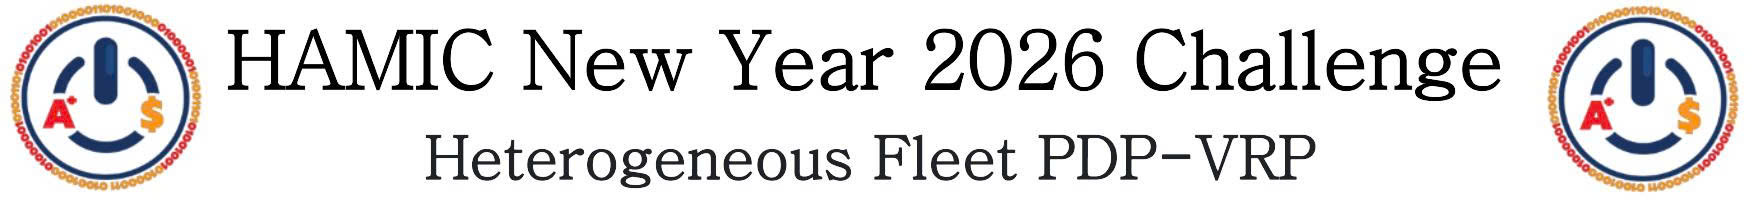

# HAMIC New Year 2026 Challenge - ALGO Task

## Starter Notebook
**Lập lịch trình cho Đội xe Đa dạng (Heterogeneous Fleet PDP-VRP) - Naive Greedy**

## Giới thiệu

Chào mừng bạn đến với HAMIC New Year 2026 Challenge!

Trong notebook khởi động này, chúng tôi sẽ hướng dẫn bạn quy trình xây dựng một thuật toán tối ưu hóa vận chuyển đơn giản (Naive Greedy) trên bộ dữ liệu mẫu để giải quyết bài toán HF PDP-VRP.

### Nội dung chính:

1.  **Cài đặt và Thư viện:** Thiết lập môi trường cần thiết.
2.  **Tải Dữ liệu:** Tải xuống bộ dữ liệu mẫu `dataset.txt` từ GitHub.
3.  **Chuẩn bị Dữ liệu:** Đọc và tiền xử lý dữ liệu đầu vào (Parsing).
4.  **Thuật toán Baseline:** Triển khai thuật toán tham lam (Greedy) cơ bản.
5.  **Đánh giá Kết quả:** Kiểm tra tính hợp lệ và thống kê sơ bộ.
6.  **Dự đoán & Nộp bài:** Tạo file kết quả `submission.csv` để nộp bài.

**Trước khi bắt đầu:**
*   Khuyên dùng **CPU mạnh** (High-RAM nếu có thể) để xử lý dữ liệu lớn nhanh hơn. Trong Colab: Chọn `Runtime` -> `Change runtime type` -> `High-RAM` (nếu có) hoặc `Standard`.


### Bước 1: Tải và Chuẩn bị Dữ liệu

Đầu tiên, chúng ta tải dữ liệu từ GitHub thông qua đường dẫn trực tiếp (Raw URL).
Sau đó, kiểm tra xem file đã được tải về thành công hay chưa.


In [34]:
import os
import sys
import math
import csv
import collections
import pandas as pd
import pandas.api.types
from typing import Dict, List, Tuple, Optional, Any

# Cấu hình đường dẫn
DATA_URL = "https://raw.githubusercontent.com/HaianCao/HAMIC_New_Year_2026_Challenge/main/task-dataset/ALGO_Task/dataset.txt"
INPUT_FILE = "dataset.txt"
OUTPUT_FILE = "submission.csv"

In [35]:
# Hàm tải dữ liệu
def download_data():
    print(f"Đang tải dữ liệu từ {DATA_URL}...")
    # Sử dụng wget để tải file
    os.system(f"wget -O {INPUT_FILE} {DATA_URL}")
    print("Đã tải xong.")

download_data()

# Kiểm tra dữ liệu
if os.path.exists(INPUT_FILE):
    print(f"Dữ liệu sẵn sàng tại: {INPUT_FILE}")
else:
    print("Vui lòng kiểm tra lại quá trình tải dữ liệu.")


Đang tải dữ liệu từ https://raw.githubusercontent.com/HaianCao/HAMIC_New_Year_2026_Challenge/main/task-dataset/ALGO_Task/dataset.txt...
Đã tải xong.
Dữ liệu sẵn sàng tại: dataset.txt


### Bước 2: Xây dựng Bộ Đọc Dữ liệu (Parsing)

Chúng ta tạo hàm `parse_input_file` để đọc nội dung file văn bản và chuyển đổi thành cấu trúc dictionary:
1.  Đọc từng dòng, tách các phần `Test`, `Vehicle`, `Order`.
2.  Lưu trữ thông tin chi tiết (Capacity, Price, Coordinates).


In [36]:
def parse_input_file(filename):
    data = {}
    current_test = None
    section = None

    with open(filename, "r") as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()
        if not line:
            continue

        if line.startswith("Test "):
            current_test = line.split(" ")[1]
            data[current_test] = {"vehicles": {}, "orders": {}}
            section = None
            continue

        if line == "Vehicle":
            section = "vehicle"
            continue

        if line == "Order":
            section = "order"
            continue

        if "ID,Capacity" in line or "ID,Weight" in line:
            continue

        # Parse content
        parts = line.split(',')
        if section == "vehicle":
            # ID,Capacity,Price,Start_X,Start_Y
            v_id = parts[0]
            data[current_test]["vehicles"][v_id] = {
                "capacity": float(parts[1]),
                "price": float(parts[2]),
                "start": [float(parts[3]), float(parts[4])]
            }
        elif section == "order":
            # ID,Weight,Pickup_X,Pickup_Y,Delivery_X,Delivery_Y
            o_id = parts[0]
            data[current_test]["orders"][o_id] = {
                "weight": float(parts[1]),
                "pickup": [float(parts[2]), float(parts[3])],
                "delivery": [float(parts[4]), float(parts[5])]
            }

    return data

In [37]:
# Load dữ liệu
if os.path.exists(INPUT_FILE):
    all_tests = parse_input_file(INPUT_FILE)
    print(f"Đã đọc xong {len(all_tests)} Test Cases.")
else:
    all_tests = {}

Đã đọc xong 200 Test Cases.


### Bước 3: Xây dựng và Chạy Thuật toán (Algorithm)

Chúng ta định nghĩa hàm `solve_baseline` (Naive Greedy) với logic đơn giản:
-   **Assignment:** Gán đơn hàng theo vòng (Round-Robin) cho các xe đủ tải trọng.
-   **Routing:** Xe đi lấy hàng rồi giao ngay lập tức (P -> D).


In [38]:
def solve_baseline(tests):
    solutions = []
    global_id_counter = 1

    print("Đang chạy thuật toán Baseline...")

    for test_id, test_data in tests.items():
        vehicles = sorted(list(test_data["vehicles"].keys()))
        orders = sorted(list(test_data["orders"].keys()))

        # Lấy thông tin capacity
        vehicle_caps = {v: test_data["vehicles"][v]["capacity"] for v in vehicles}

        vehicle_routes = collections.defaultdict(list)
        rr_idx = 0

        for o_id in orders:
            o_weight = test_data["orders"][o_id]["weight"]

            # Tìm danh sách xe hợp lệ
            valid_vehicles = [v for v in vehicles if vehicle_caps[v] >= o_weight]

            if not valid_vehicles:
                print(f"Warning: Test {test_id} - Order {o_id} không có xe nào chở được!")
                chosen_v = vehicles[0]
            else:
                # Chọn xe round-robin
                chosen_v = valid_vehicles[rr_idx % len(valid_vehicles)]
                rr_idx += 1

            # Xây dựng lộ trình
            vehicle_routes[chosen_v].append((o_id, "Pickup"))
            vehicle_routes[chosen_v].append((o_id, "Delivery"))

        # Format output
        for v_id in vehicles:
            route = vehicle_routes.get(v_id, [])
            for idx, (oid, otype) in enumerate(route, 1):
                solutions.append([
                    global_id_counter,
                    test_id,
                    v_id,
                    oid,
                    otype,
                    idx
                ])
                global_id_counter += 1

    return solutions

In [39]:
# Chạy thuật toán
if all_tests:
    baseline_solutions = solve_baseline(all_tests)
    print(f"Đã tạo ra {len(baseline_solutions)} dòng kết quả.")

Đang chạy thuật toán Baseline...
Đã tạo ra 63802 dòng kết quả.


## Bước 4: Đánh giá Kết quả (Evaluation)

Tính Mean Efficiency Score (MES)

In [40]:
def normalize_id(val) -> str:
    v_str = str(val).strip()
    try:
        return str(int(float(v_str)))
    except ValueError:
        return v_str

class ProblemInstance:
    def __init__(self, test_id: int):
        self.test_id = test_id
        self.vehicles = {}
        self.orders = {}
        self.min_vehicle_price = float('inf')

    def add_vehicle(self, v_id, capacity, price, start_x, start_y):
        clean_id = normalize_id(v_id)
        self.vehicles[clean_id] = {
            "capacity": capacity,
            "price": price,
            "start": (start_x, start_y)
        }
        if price < self.min_vehicle_price:
            self.min_vehicle_price = price

    def add_order(self, o_id, weight, p_x, p_y, d_x, d_y):
        clean_id = normalize_id(o_id)
        self.orders[clean_id] = {
            "weight": weight,
            "pickup": (p_x, p_y),
            "delivery": (d_x, d_y)
        }

    def get_lower_bound(self) -> float:
        if not self.vehicles or not self.orders:
            return 0.0
        total_direct_dist = sum(
            math.sqrt((o["pickup"][0] - o["delivery"][0])**2 + (o["pickup"][1] - o["delivery"][1])**2)
            for o in self.orders.values()
        )
        return total_direct_dist * self.min_vehicle_price

class InputParser:
    @staticmethod
    def parse(filepath: str) -> Dict[int, ProblemInstance]:
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Dataset not found at: {filepath}")

        tests = {}
        current_test = None
        section = None

        with open(filepath, "r") as f:
            lines = f.readlines()

        for line in lines:
            line = line.strip()
            if not line: continue

            if line.startswith("Test "):
                try:
                    t_id = int(line.split(" ")[1])
                    current_test = ProblemInstance(t_id)
                    tests[t_id] = current_test
                    section = None
                except ValueError: pass
                continue

            if line == "Vehicle": section = "Vehicle"; continue
            if line == "Order": section = "Order"; continue
            if line.startswith("ID,"): continue

            if current_test:
                parts = line.split(",")
                if section == "Vehicle" and len(parts) >= 5:
                    current_test.add_vehicle(parts[0], float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4]))
                elif section == "Order" and len(parts) >= 6:
                    current_test.add_order(parts[0], float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4]), float(parts[5]))
        return tests

class ValidationLogger:
    def __init__(self):
        self.logs = []
    def log_error(self, test_id, v_id, o_id, error_type, message, details=""):
        self.logs.append({"Test": test_id, "Error": error_type, "Message": message, "Details": details})
    def print_detailed_report(self):
        if not self.logs: return
        print(f"VALIDATION FAILED: {len(self.logs)} errors.")
        print(pd.DataFrame(self.logs).head(20))

class RouteValidator:
    @staticmethod
    def dist(p1, p2):
        return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

    @staticmethod
    def evaluate_test_case(instance, submission_df, logger) -> float:
        df = submission_df[submission_df['Test'] == instance.test_id].copy()
        if df.empty: return float('inf')

        # Robust Stop_Order
        if 'Stop_Order' not in df.columns: return float('inf')
        df['Stop_Order'] = pd.to_numeric(df['Stop_Order'], errors='coerce')
        df = df.sort_values(by=['Vehicle_ID', 'Stop_Order'], ascending=[True, True])

        states = {oid: "PENDING" for oid in instance.orders}
        vehicle_ownership = {}
        total_cost = 0.0
        test_failed = False

        for v_id, route in df.groupby('Vehicle_ID', sort=False):
            if v_id not in instance.vehicles:
                logger.log_error(instance.test_id, v_id, "-", "Unknown ID", "Vehicle ID not found")
                test_failed = True; continue

            v_data = instance.vehicles[v_id]
            curr_load = 0.0
            curr_pos = v_data['start']

            for _, row in route.iterrows():
                o_id = row['Order_ID']
                act = str(row['Type']).strip()

                if o_id not in instance.orders:
                    test_failed = True; break

                o_data = instance.orders[o_id]
                target = None

                if act == 'Pickup':
                    if states[o_id] != "PENDING":
                        test_failed = True
                    else:
                        target = o_data['pickup']
                        curr_load += o_data['weight']
                        states[o_id] = "PICKED"
                        vehicle_ownership[o_id] = v_id

                elif act == 'Delivery':
                    if states[o_id] != "PICKED" or vehicle_ownership.get(o_id) != v_id:
                        test_failed = True
                    else:
                        target = o_data['delivery']
                        curr_load -= o_data['weight']
                        states[o_id] = "DELIVERED"

                if curr_load > v_data['capacity'] + 1e-9:
                    logger.log_error(instance.test_id, v_id, o_id, "Constraint", "Capacity Exceeded")
                    test_failed = True

                if target:
                    total_cost += RouteValidator.dist(curr_pos, target) * v_data['price']
                    curr_pos = target

        if any(v != "DELIVERED" for v in states.values()):
            logger.log_error(instance.test_id, "ALL", "ALL", "Completeness", "Unserved Orders")
            test_failed = True

        return float('inf') if test_failed else total_cost

def calculate_score(input_path, solution_df):
    data = InputParser.parse(input_path)
    logger = ValidationLogger()
    total_efficiency = 0.0
    valid_test_count = 0

    # Pre-process solution_df
    if 'Test' in solution_df.columns:
        solution_df['Test'] = pd.to_numeric(solution_df['Test'], errors='coerce').fillna(-1).astype(int)
    if 'Vehicle_ID' in solution_df.columns: solution_df['Vehicle_ID'] = solution_df['Vehicle_ID'].apply(normalize_id)
    if 'Order_ID' in solution_df.columns: solution_df['Order_ID'] = solution_df['Order_ID'].apply(normalize_id)

    target_tests = set(solution_df['Test'].unique())
    active_tests = {t: d for t,d in data.items() if t in target_tests}

    for t_id, instance in active_tests.items():
        lower_bound = instance.get_lower_bound()
        if lower_bound <= 1e-9: continue

        cost = RouteValidator.evaluate_test_case(instance, solution_df, logger)

        if cost != float('inf'):
            efficiency = cost / lower_bound
            total_efficiency += efficiency
            valid_test_count += 1

    if logger.logs:
        logger.print_detailed_report()
        print("Có lỗi xảy ra trong quá trình kiểm tra.")
    else:
        print(f"Validation Passed!")

    final_score = total_efficiency / valid_test_count if valid_test_count > 0 else float('inf')
    print(f"Mean Efficiency Score: {final_score:.4f}")
    return final_score

In [41]:
# Chạy đánh giá
if 'baseline_solutions' in locals() and os.path.exists(INPUT_FILE):
    df_sol = pd.DataFrame(baseline_solutions, columns=["ID", "Test", "Vehicle_ID", "Order_ID", "Type", "Stop_Order"])
    calculate_score(INPUT_FILE, df_sol)

Validation Passed!
Mean Efficiency Score: 21.8224


### Bước 5: Tạo File Nộp bài (Submission)

Cuối cùng, ghi kết quả vào file `submission.csv` theo đúng định dạng yêu cầu.


In [42]:
def write_submission(solutions, filename):
    if not solutions:
        print("Danh sách kết quả rỗng, không thể tạo file.")
        return

    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        # Header chuẩn
        writer.writerow(["ID", "Test", "Vehicle_ID", "Order_ID", "Type", "Stop_Order"])
        writer.writerows(solutions)

    print(f"Đã lưu {filename} thành công!")

# Lưu file
if 'baseline_solutions' in locals():
    write_submission(baseline_solutions, OUTPUT_FILE)

Đã lưu submission.csv thành công!
